In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [ ]:
# 1. Load daily data and resample to weekly means (Sun-anchored)

df = pd.read_csv("../data/processed/water_levels_daily.csv", parse_dates=["timestamp"])
weekly = (
    df.set_index("timestamp")["value"]
      .resample("W-SUN").mean()
      .interpolate()
)

# keep as single-column frame for convenience
weekly_df = weekly.to_frame(name="value")

# ------------------------------------------------------------------
# 2. Dynamic cap – same helper as in the SARIMA notebook -------------
anchor_template = [
    ("11-01", 237.30), ("12-15", 237.30), ("01-01", 239.61),
    ("02-01", 241.71), ("03-01", 242.70), ("04-01", 244.10),
    ("05-01", 244.95),
]

def compute_max_level_series(dates):
    def max_level_on(date):
        y0 = date.year if date.month >= 11 else date.year - 1
        pts = []
        for md, lvl in anchor_template:
            mon, day = map(int, md.split("-"))
            yr = y0 if mon >= 11 else y0 + 1
            try:
                pts.append((pd.Timestamp(yr, mon, day), lvl))
            except ValueError:
                # fallback for Feb-29 on non-leap years
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]
    return pd.Series([max_level_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(weekly_df.index)


# Precompute Fourier features (same as SARIMA)
periods = [52]
t = np.arange(len(weekly))
fourier_terms = pd.DataFrame(index=weekly.index)
for P in periods:
    fourier_terms[f"sin_{P}w"] = np.sin(2 * np.pi * t / P)
    fourier_terms[f"cos_{P}w"] = np.cos(2 * np.pi * t / P)

# Create combined feature DataFrame
df_features = weekly_df.copy()

# Add Fourier Features
df_features = df_features.join(fourier_terms)

# Add Cyclical Week of Year
df_features['weekofyear'] = df_features.index.isocalendar().week.astype(float)
df_features['sin_week'] = np.sin(2 * np.pi * df_features['weekofyear'] / 52)
df_features['cos_week'] = np.cos(2 * np.pi * df_features['weekofyear'] / 52)
df_features = df_features.drop(columns=['weekofyear']) # Drop the original week number

# Optionally: Add max_level as a feature (uncomment if desired)
# df_features = df_features.join(max_level)
# df_features = df_features.rename(columns={'max_level_m': 'max_level_feat'}) # Avoid name clash later

print("Feature DataFrame head:")
print(df_features.head())
print("\nFeature DataFrame columns:")
print(df_features.columns)

# Define feature columns and target column
TARGET_COL = 'value'
FEATURE_COLS = [col for col in df_features.columns if col != TARGET_COL]
ALL_COLS = df_features.columns.tolist() # Order matters for scaling/inverse

# ------------------------------------------------------------------
# 3. Train / validation / test split ----------------------------------
train_df = df_features.loc[:"2017-12-31"]
validation_df = df_features.loc["2018-01-01":"2020-12-31"]
# test_df = df_features.loc["2021-01-01":] # kept for later

# ------------------------------------------------------------------
# 4. Scaling – fit only on training -----------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled      = scaler.fit_transform(train_df)
validation_scaled = scaler.transform(validation_df)

# ------------------------------------------------------------------
# 5. Helper to build lookback / horizon windows -----------------------
LOOKBACK = 52           # weeks history
HORIZON  = 4            # 4-week ahead target


def make_windows(arr, lookback=LOOKBACK, horizon=HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback:i, 0])
        y.append(arr[i + horizon - 1, 0])
    return np.array(X), np.array(y)

# ---------------- Training windows -----------------------------------
X_train, y_train = make_windows(train_scaled)

# ---------------- Validation windows (corrected) ---------------------
PAD_LEN = LOOKBACK + HORIZON - 1   # History required before val starts
padding   = train_scaled[-PAD_LEN:]              # last PAD_LEN train rows
val_block = np.vstack([padding, validation_scaled])

X_val, y_val = make_windows(val_block)

# validation_pred_dates should now match validation_df.index exactly
# Verify the length: should be len(validation_df)
assert len(X_val) == len(validation_df), "Length mismatch!"

validation_pred_dates = validation_df.index # Assign the full index

# reshape to Keras 3-D format
X_train = X_train.reshape((-1, LOOKBACK, 1)).astype("float32")
X_val   = X_val  .reshape((-1, LOOKBACK, 1)).astype("float32")

# ------------------------------------------------------------------
# 6. LSTM model (identical to user baseline) --------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.1),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=2,
)

Length of validation_df: 156
Length of X_val: 156
Length of y_val: 156
Epoch 1/100


c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 - 2s - 74ms/step - loss: 0.1098 - val_loss: 0.1271
Epoch 2/100
28/28 - 0s - 16ms/step - loss: 0.0620 - val_loss: 0.0982
Epoch 3/100
28/28 - 0s - 16ms/step - loss: 0.0457 - val_loss: 0.0566
Epoch 4/100
28/28 - 0s - 16ms/step - loss: 0.0318 - val_loss: 0.0399
Epoch 5/100
28/28 - 0s - 16ms/step - loss: 0.0297 - val_loss: 0.0350
Epoch 6/100
28/28 - 0s - 17ms/step - loss: 0.0293 - val_loss: 0.0357
Epoch 7/100
28/28 - 0s - 17ms/step - loss: 0.0268 - val_loss: 0.0365
Epoch 8/100
28/28 - 0s - 16ms/step - loss: 0.0273 - val_loss: 0.0321
Epoch 9/100
28/28 - 0s - 16ms/step - loss: 0.0258 - val_loss: 0.0304
Epoch 10/100
28/28 - 0s - 16ms/step - loss: 0.0255 - val_loss: 0.0287
Epoch 11/100
28/28 - 0s - 16ms/step - loss: 0.0243 - val_loss: 0.0289
Epoch 12/100
28/28 - 0s - 16ms/step - loss: 0.0243 - val_loss: 0.0398
Epoch 13/100
28/28 - 0s - 16ms/step - loss: 0.0235 - val_loss: 0.0230
Epoch 14/100
28/28 - 0s - 16ms/step - loss: 0.0228 - val_loss: 0.0214
Epoch 15/100
28/28 - 0s - 16ms/step - los

In [30]:
# 7. Forecast on validation period ------------------------------------
validation_predictions = model.predict(X_val, verbose=0).flatten()
validation_actual      = y_val

# inverse‑transform ----------------------------------------------------
validation_predictions = scaler.inverse_transform(validation_predictions.reshape(-1, 1)).flatten()
validation_actual      = scaler.inverse_transform(validation_actual.reshape(-1, 1)).flatten()

# capping --------------------------------------------------------------
MIN_VAL = 205.0
cap_val = max_level.loc[validation_pred_dates].values
predictions_capped = np.maximum(validation_predictions, MIN_VAL)
predictions_final  = np.minimum(predictions_capped, cap_val)

# ------------------------------------------------------------------
# 8. Metrics -----------------------------------------------------------
validation_results = pd.DataFrame({
    "Actual":    validation_actual,
    "Predicted": predictions_final,
}, index=validation_pred_dates)

rmse = np.sqrt(mean_squared_error(validation_results["Actual"], validation_results["Predicted"]))
mae  = mean_absolute_error(validation_results["Actual"], validation_results["Predicted"])

metrics_df = pd.DataFrame({"Metric": ["MAE", "RMSE"], "Value": [mae, rmse]})

metrics_df

,Metric,Value
0,MAE,2.243778
1,RMSE,2.875475


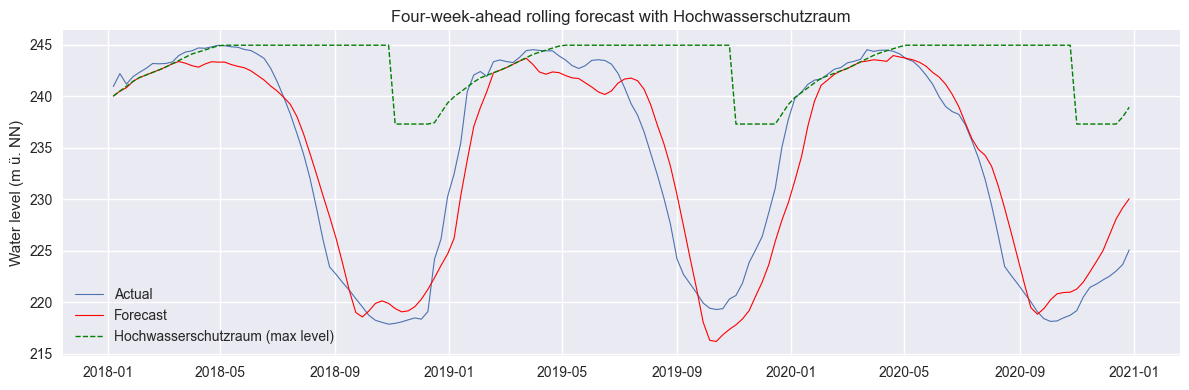

In [31]:
fig, ax = plt.subplots(figsize=(12,4))

# 1) plot actuals & forecasts
ax.plot(validation_results.index, validation_results['Actual'], label='Actual', lw=.8)
ax.plot(validation_results.index, validation_results['Predicted'], label='Forecast', color='red', lw=.8)

# 2) plot the buffer‐level (max allowed) as a dashed line
ax.plot(max_level.loc[validation_pred_dates],
        label='Hochwasserschutzraum (max level)',
        color='green', linestyle='--', lw=1)


ax.set_title("Four-week-ahead rolling forecast with Hochwasserschutzraum")
ax.set_ylabel("Water level (m ü. NN)")
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

## o3

c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


----------------------------------------
Validation MAE  :  1.80
Validation RMSE :  2.34
----------------------------------------


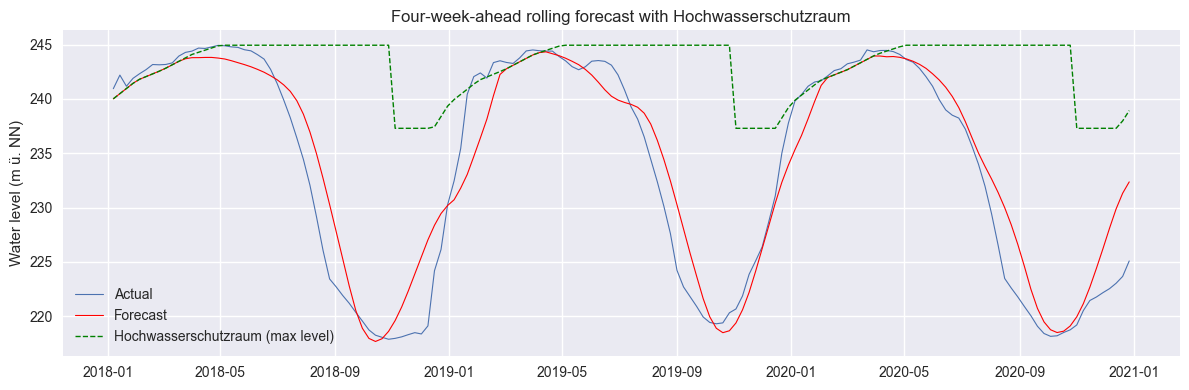

In [37]:
# ---------------------------------------------------------------
# 0. Imports
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.auto import tqdm

# ---------------------------------------------------------------
# 1. Load daily data → weekly means (Sun-anchored)
# ---------------------------------------------------------------
df = pd.read_csv("../data/processed/water_levels_daily.csv",
                 parse_dates=["timestamp"])

weekly = (
    df.set_index("timestamp")["value"]
      .resample("W-SUN").mean()
      .interpolate()
)

# ---------------------------------------------------------------
# 2. Build DataFrame with deterministic seasonality
#    – keep target 'value' in the first column
# ---------------------------------------------------------------
weekly_df = weekly.to_frame(name="value")

week_no = weekly_df.index.isocalendar().week.astype(int)    # 1 … 52/53
weekly_df["sin52"] = np.sin(2 * np.pi * week_no / 52)
weekly_df["cos52"] = np.cos(2 * np.pi * week_no / 52)

# second harmonic (optional but usually helpful)
weekly_df["sin26"] = np.sin(2 * np.pi * week_no / 26)
weekly_df["cos26"] = np.cos(2 * np.pi * week_no / 26)

# keep column order
weekly_df = weekly_df[["value", "sin52", "cos52", "sin26", "cos26"]]

# ---------------------------------------------------------------
# 3. Dynamic cap
# ---------------------------------------------------------------
anchor_template = [
    ("11-01", 237.30), ("12-15", 237.30), ("01-01", 239.61),
    ("02-01", 241.71), ("03-01", 242.70), ("04-01", 244.10),
    ("05-01", 244.95),
]

def compute_max_level_series(dates):
    def max_level_on(date):
        y0 = date.year if date.month >= 11 else date.year - 1
        pts = []
        for md, lvl in anchor_template:
            m, d = map(int, md.split("-"))
            yr = y0 if m >= 11 else y0 + 1
            # handle 29 Feb on non-leap yrs
            try:
                pts.append((pd.Timestamp(yr, m, d), lvl))
            except ValueError:
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]

    return pd.Series([max_level_on(d) for d in dates], index=dates,
                     name="max_level_m")

max_level = compute_max_level_series(weekly_df.index)

# ---------------------------------------------------------------
# 4. Train / validation split
# ---------------------------------------------------------------
train_df      = weekly_df.loc[: "2017-12-31"]
validation_df = weekly_df.loc["2018-01-01" : "2020-12-31"]

# ---------------------------------------------------------------
# 5. Scaling
# ---------------------------------------------------------------
scaler = StandardScaler()
train_scaled      = scaler.fit_transform(train_df)
validation_scaled = scaler.transform(validation_df)

# ---------------------------------------------------------------
# 6. Window generator 
# ---------------------------------------------------------------
LOOKBACK = 52        # weeks
HORIZON  = 4         # predict t + 3 (4-week ahead)

def make_windows(arr, lookback=LOOKBACK, horizon=HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback : i, :])     # all features
        y.append(arr[i + horizon - 1, 0])      # only 'value'
    return np.array(X), np.array(y)

# -------- training windows ----------
X_train, y_train = make_windows(train_scaled)

# -------- validation windows --------
PAD_LEN   = LOOKBACK + HORIZON - 1
padding   = train_scaled[-PAD_LEN:]
val_block = np.vstack([padding, validation_scaled])
X_val, y_val = make_windows(val_block)

# to Keras shapes
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")

# ---------------------------------------------------------------
# 7. LSTM model
# ---------------------------------------------------------------
n_features = X_train.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=20,
                   restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=0,
)

# ---------------------------------------------------------------
# 8. Forecast on validation set
# ---------------------------------------------------------------
validation_pred_scaled = model.predict(X_val, verbose=0).flatten()
validation_act_scaled  = y_val

# ---------- NEW inverse-scaling logic (only column-0) ----------
target_mean  = scaler.mean_[0]
target_scale = scaler.scale_[0]

validation_pred = validation_pred_scaled * target_scale + target_mean
validation_act  = validation_act_scaled  * target_scale + target_mean

# ---------------------------------------------------------------
# 9. Apply dynamic cap
# ---------------------------------------------------------------
MIN_VAL = 205.0
cap_val = max_level.loc[validation_df.index].values

pred_capped = np.maximum(validation_pred, MIN_VAL)
pred_final  = np.minimum(pred_capped, cap_val)

# ---------------------------------------------------------------
# 10. Metrics
# ---------------------------------------------------------------
val_results = pd.DataFrame({
    "Actual":    validation_act,
    "Predicted": pred_final,
}, index=validation_df.index)

rmse = np.sqrt(mean_squared_error(val_results["Actual"],
                                  val_results["Predicted"]))
mae  = mean_absolute_error(val_results["Actual"],
                           val_results["Predicted"])

print("-" * 40)
print(f"Validation MAE  : {mae:5.2f}")
print(f"Validation RMSE : {rmse:5.2f}")
print("-" * 40)


# ---------------------------------------------------------------
# 11. Plot results
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12,4))

# 1) plot actuals & forecasts
ax.plot(validation_results.index, validation_results['Actual'], label='Actual', lw=.8)
ax.plot(validation_results.index, validation_results['Predicted'], label='Forecast', color='red', lw=.8)

# 2) plot the buffer‐level (max allowed) as a dashed line
ax.plot(max_level.loc[validation_pred_dates],
        label='Hochwasserschutzraum (max level)',
        color='green', linestyle='--', lw=1)


ax.set_title("Four-week-ahead rolling forecast with Hochwasserschutzraum")
ax.set_ylabel("Water level (m ü. NN)")
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Gemini 2.5 Pro

1. Loading and resampling data...
Weekly data loaded. Shape: (1322, 1)
                 value
timestamp             
2000-01-02  239.520000
2000-01-09  239.284286
2000-01-16  239.102857
2000-01-23  239.188571
2000-01-30  239.548571

2. Calculating dynamic max level...
Dynamic max level series computed.

3. Engineering features (Fourier, Cyclical Week)...
Feature DataFrame head:
                 value   sin_52w   cos_52w   sin_26w   cos_26w      sin_week  \
timestamp                                                                      
2000-01-02  239.520000  0.000000  1.000000  0.000000  1.000000  6.432491e-16   
2000-01-09  239.284286  0.120537  0.992709  0.239316  0.970942  1.205367e-01   
2000-01-16  239.102857  0.239316  0.970942  0.464723  0.885456  2.393157e-01   
2000-01-23  239.188571  0.354605  0.935016  0.663123  0.748511  3.546049e-01   
2000-01-30  239.548571  0.464723  0.885456  0.822984  0.568065  4.647232e-01   

            cos_week  
timestamp             
2000-01-02  

c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 52, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


8. Training the LSTM model...

9. Predicting on validation set and inverse transforming...

10. Applying dynamic capping...

11. Evaluating performance...

--- Validation Metrics (LSTM with Seasonality Features) ---
Validation MAE:  2.0445
Validation RMSE: 2.8165

Validation Results (Head):
                Actual   Predicted  Max_Level_Cap
timestamp                                        
2018-01-07  240.948571  240.016452     240.016452
2018-01-14  242.198571  240.490645     240.490645
2018-01-21  241.174285  240.964839     240.964839
2018-01-28  241.898571  241.439032     241.439032
2018-02-04  242.324286  241.816071     241.816071

12. Plotting results...


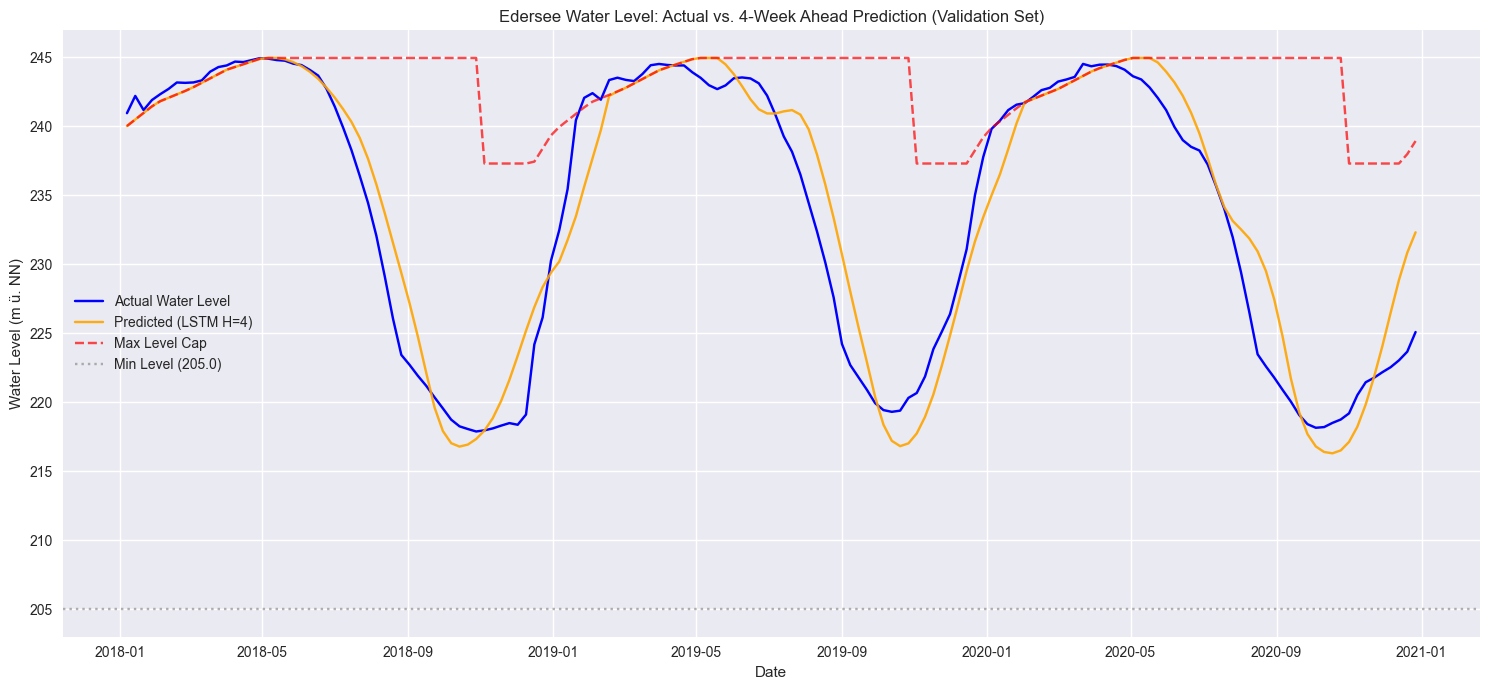


--- Script Finished ---


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Or import from standard tqdm if not in Notebook

# ------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------
LOOKBACK = 52           # weeks history to use for prediction
HORIZON  = 4            # weeks ahead to predict
MIN_VAL  = 205.0        # Plausible physical minimum water level
TRAIN_END_DATE = "2017-12-31"
VALID_START_DATE = "2018-01-01"
VALID_END_DATE = "2020-12-31"
TARGET_COL = 'value'    # Name of the column we want to predict

# LSTM Hyperparameters
LSTM_UNITS_1 = 64
LSTM_UNITS_2 = 32
DROPOUT_RATE = 0.1
EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 20

# File Path (adjust if necessary)
DATA_FILE_PATH = "../data/processed/water_levels_daily.csv"

# ------------------------------------------------------------------
# 1. Load Daily Data & Resample to Weekly Means (Sun-anchored)
# ------------------------------------------------------------------
print("1. Loading and resampling data...")
df = pd.read_csv(DATA_FILE_PATH, parse_dates=["timestamp"])
weekly = (
    df.set_index("timestamp")[TARGET_COL]
      .resample("W-SUN").mean()
      .interpolate() # Interpolate missing weekly means if any
)
weekly_df = weekly.to_frame(name=TARGET_COL) # Keep as DataFrame

print(f"Weekly data loaded. Shape: {weekly_df.shape}")
print(weekly_df.head())

# ------------------------------------------------------------------
# 2. Hochwasserschutzraum Max Level Calculation
# ------------------------------------------------------------------
print("\n2. Calculating dynamic max level...")
anchor_template = [
    ("11-01", 237.30), ("12-15", 237.30), ("01-01", 239.61),
    ("02-01", 241.71), ("03-01", 242.70), ("04-01", 244.10),
    ("05-01", 244.95),
]

def compute_max_level_series(dates):
    """Computes the weekly 'max_level' by piecewise-linear interpolation."""
    def max_level_on(date):
        # Determine the 'management year' Nov1(date.year) -> May1(date.year+1)
        y0 = date.year if date.month >= 11 else date.year - 1
        # Build the seven anchor datetimes for this cycle
        pts = []
        for md, lvl in anchor_template:
            mon, day = map(int, md.split("-"))
            year = y0 if mon >= 11 else y0 + 1
            try:
                pts.append((pd.Timestamp(year, mon, day), lvl))
            except ValueError: # Handle Feb 29 on non-leap years
                 if mon == 2 and day == 29:
                     # Use Feb 28 instead on non-leap years
                     pts.append((pd.Timestamp(year, 2, 28), lvl))
                 else: raise # re-raise other potential errors
        pts.sort(key=lambda x: x[0])
        # If before Nov 1 or after May 1: full capacity (Stauziel 1)
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1] # Return the level associated with May 1st
        # Find segment containing the date and interpolate
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                # Avoid division by zero if dates are identical (unlikely with sorted unique dates)
                if d1 == d0: return l0
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        # Fallback (should technically not be reached if date is within Nov-May range)
        return pts[-1][1]

    return pd.Series([max_level_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(weekly_df.index)
print("Dynamic max level series computed.")

# ------------------------------------------------------------------
# 3. Feature Engineering: Add Seasonality
# ------------------------------------------------------------------
print("\n3. Engineering features (Fourier, Cyclical Week)...")

# Precompute Fourier features (annual seasonality)
periods = [52, 26] # Weeks in a year
t = np.arange(len(weekly_df))
fourier_terms = pd.DataFrame(index=weekly_df.index)
for P in periods:
    fourier_terms[f"sin_{P}w"] = np.sin(2 * np.pi * t / P)
    fourier_terms[f"cos_{P}w"] = np.cos(2 * np.pi * t / P)

# Create combined feature DataFrame
df_features = weekly_df.copy()

# Add Fourier Features
df_features = df_features.join(fourier_terms)

# Add Cyclical Week of Year
df_features['weekofyear'] = df_features.index.isocalendar().week.astype(float)
df_features['sin_week'] = np.sin(2 * np.pi * df_features['weekofyear'] / 52) # Use 52 weeks
df_features['cos_week'] = np.cos(2 * np.pi * df_features['weekofyear'] / 52)
df_features = df_features.drop(columns=['weekofyear']) # Drop the original week number

# Optionally: Add max_level itself as a feature (Uncomment if desired)
# df_features = df_features.join(max_level)
# df_features = df_features.rename(columns={'max_level_m': 'max_level_feat'}) # Avoid name clash later

print("Feature DataFrame head:")
print(df_features.head())
print("\nFeature DataFrame columns:")
print(df_features.columns)

# Define feature columns and target column
# TARGET_COL is defined above
FEATURE_COLS = [col for col in df_features.columns if col != TARGET_COL]
ALL_COLS = df_features.columns.tolist() # Order matters for scaling/inverse

# ------------------------------------------------------------------
# 4. Train / Validation Split
# ------------------------------------------------------------------
print("\n4. Splitting data into Train/Validation sets...")
train_df = df_features.loc[:TRAIN_END_DATE]
validation_df = df_features.loc[VALID_START_DATE:VALID_END_DATE]
# test_df = df_features.loc["2021-01-01":] # Keep definition for potential future use

print(f"Training set shape:   {train_df.shape}")
print(f"Validation set shape: {validation_df.shape}")

# ------------------------------------------------------------------
# 5. Scaling (Fit only on Training Data)
# ------------------------------------------------------------------
print("\n5. Scaling data (MinMaxScaler)...")

# Scale ALL features and target together using one scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler ONLY on training data (NumPy array expected)
scaler.fit(train_df.values)

# Transform train and validation sets into NumPy arrays
train_scaled = scaler.transform(train_df.values)
validation_scaled = scaler.transform(validation_df.values)

# Get the column index of the target variable *after* scaling
# This is crucial for make_windows and inverse_transform
try:
    TARGET_COL_INDEX = ALL_COLS.index(TARGET_COL)
    print(f"Target column '{TARGET_COL}' is at index: {TARGET_COL_INDEX}")
except ValueError:
    raise ValueError(f"Target column '{TARGET_COL}' not found in DataFrame columns: {ALL_COLS}")

NUM_FEATURES = train_scaled.shape[1] # Total number of features including target
print(f"Number of features (including target) after scaling: {NUM_FEATURES}")

# ------------------------------------------------------------------
# 6. Helper to Build Lookback / Horizon Windows (Multi-Feature)
# ------------------------------------------------------------------
print("\n6. Creating lookback/horizon windows...")

def make_windows_multi_feature(
    data_scaled_array, # Input should be the scaled numpy array
    target_col_index,  # Index of the column we want to predict
    lookback=LOOKBACK,
    horizon=HORIZON
):
    """
    Creates input (X) and output (y) windows for time series forecasting
    with multiple features.
    X shape: (n_samples, lookback, n_features)
    y shape: (n_samples,) - contains the target value at the horizon
    """
    X, y = [], []
    num_samples = len(data_scaled_array)
    num_features = data_scaled_array.shape[1] # Get number of features from input array

    if num_samples < lookback + horizon:
        print(f"Warning: Not enough data ({num_samples} samples) to create windows with lookback={lookback} and horizon={horizon}.")
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    for i in range(lookback, num_samples - horizon + 1):
        # Features: lookback window across all columns
        feature_window = data_scaled_array[i - lookback : i, :]
        X.append(feature_window)

        # Target: Scaled value from the target column at the specified horizon
        target_val = data_scaled_array[i + horizon - 1, target_col_index]
        y.append(target_val)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# --- Create Training windows ---
X_train, y_train = make_windows_multi_feature(
    train_scaled, TARGET_COL_INDEX, LOOKBACK, HORIZON
)

# --- Create Validation windows (Handle Padding Correctly) ---
# We need enough history from the *end* of the training set to form the
# first few prediction windows for the validation set.
PAD_LEN = LOOKBACK + HORIZON - 1   # History required before validation starts

if len(train_scaled) < PAD_LEN:
     raise ValueError(f"Training data length ({len(train_scaled)}) is too short for the required padding ({PAD_LEN}) needed for validation window creation (Lookback={LOOKBACK}, Horizon={HORIZON}). Increase training data or decrease lookback/horizon.")

# Get the last PAD_LEN rows from the scaled TRAINING data array
padding = train_scaled[-PAD_LEN:]

# Combine padding with the scaled validation data array
# This block contains the necessary history + the actual validation data
val_block = np.vstack([padding, validation_scaled])

# Create validation windows using the combined block
X_val, y_val = make_windows_multi_feature(
    val_block, TARGET_COL_INDEX, LOOKBACK, HORIZON
)

# --- Validation Dates ---
# The dates corresponding to the *target* predictions in y_val
# These should align with the original validation_df dates
validation_pred_dates = validation_df.index # These are the dates we are predicting FOR

# --- Verification ---
# The number of validation predictions (len(y_val)) should match the number of
# possible forecast start points within the validation period.
# The first prediction corresponds to the target at index (LOOKBACK + HORIZON - 1)
# in the val_block, which aligns with the first date in validation_df.index.
# The last prediction uses history up to index -(HORIZON) and predicts index -1.
# So, the number of predictions should equal len(validation_scaled).
# len(y_val) derived from val_block = len(val_block) - lookback - horizon + 1
# len(val_block) = len(padding) + len(validation_scaled) = PAD_LEN + len(validation_scaled)
# len(y_val) = (PAD_LEN + len(validation_scaled)) - LOOKBACK - HORIZON + 1
# len(y_val) = (LOOKBACK + HORIZON - 1 + len(validation_scaled)) - LOOKBACK - HORIZON + 1
# len(y_val) = len(validation_scaled)
# Since validation_scaled came from validation_df, len(y_val) == len(validation_df)
expected_val_samples = len(validation_df)
if len(y_val) != expected_val_samples:
    print(f"Warning: Length mismatch! y_val has {len(y_val)} samples, expected {expected_val_samples} based on validation_df length.")
    # If this warning appears, double-check windowing/padding logic.
    # It might mean the validation_pred_dates alignment is off.
    # Trim validation_pred_dates if necessary (though it shouldn't be needed with correct logic)
    # validation_pred_dates = validation_pred_dates[:len(y_val)]


print(f"X_train shape: {X_train.shape}") # (samples, lookback, features)
print(f"y_train shape: {y_train.shape}") # (samples,)
print(f"X_val shape:   {X_val.shape}")   # (samples, lookback, features)
print(f"y_val shape:   {y_val.shape}")   # (samples,)
print(f"Number of validation prediction dates: {len(validation_pred_dates)}")

# ------------------------------------------------------------------
# 7. LSTM Model Definition
# ------------------------------------------------------------------
print("\n7. Defining the LSTM model...")

tf.keras.backend.clear_session() # Clear previous model states if any

model = Sequential([
    # Input shape is (LOOKBACK, NUM_FEATURES)
    LSTM(LSTM_UNITS_1, return_sequences=True, input_shape=(LOOKBACK, NUM_FEATURES)),
    Dropout(DROPOUT_RATE),
    LSTM(LSTM_UNITS_2, return_sequences=False), # Only last output needed for Dense layer
    Dropout(DROPOUT_RATE),
    Dense(1) # Predicts a single scaled value (the target at horizon)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

# ------------------------------------------------------------------
# 8. Model Training
# ------------------------------------------------------------------
print("\n8. Training the LSTM model...")

es = EarlyStopping(
    monitor="val_loss",          # Monitor validation loss
    patience=EARLY_STOPPING_PATIENCE, # Stop if no improvement after N epochs
    restore_best_weights=True    # Keep the weights from the best epoch
)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=0, # Show progress per epoch
)

# ------------------------------------------------------------------
# 9. Forecast on Validation Period & Inverse Transform
# ------------------------------------------------------------------
print("\n9. Predicting on validation set and inverse transforming...")

# Predict using the validation features (X_val) -> returns scaled predictions
validation_predictions_scaled = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0).flatten()

# Actual scaled values are in y_val
validation_actual_scaled = y_val

# --- Inverse Transform Predictions ---
# Create a dummy array matching the shape the scaler expects (samples, num_features)
# Initialize with zeros (or another placeholder)
dummy_array_pred = np.zeros((len(validation_predictions_scaled), NUM_FEATURES))
# Place the scaled predictions into the correct column index for the target variable
dummy_array_pred[:, TARGET_COL_INDEX] = validation_predictions_scaled
# Inverse transform the entire dummy array
validation_predictions_inv = scaler.inverse_transform(dummy_array_pred)
# Extract only the column corresponding to the inverse-transformed target variable
validation_predictions = validation_predictions_inv[:, TARGET_COL_INDEX]


# --- Inverse Transform Actual Values (for comparison) ---
# Repeat the process for the actual scaled values (y_val)
dummy_array_actual = np.zeros((len(validation_actual_scaled), NUM_FEATURES))
dummy_array_actual[:, TARGET_COL_INDEX] = validation_actual_scaled
validation_actual_inv = scaler.inverse_transform(dummy_array_actual)
validation_actual = validation_actual_inv[:, TARGET_COL_INDEX]

# ------------------------------------------------------------------
# 10. Apply Capping based on Hochwasserschutzraum
# ------------------------------------------------------------------
print("\n10. Applying dynamic capping...")

# Get the max level caps corresponding to the prediction dates
# Ensure alignment using validation_pred_dates
if len(validation_pred_dates) != len(validation_predictions):
     print("Warning: Mismatch between number of prediction dates and predictions. Adjusting dates.")
     # This shouldn't happen with correct windowing logic, but as a fallback:
     validation_pred_dates = validation_pred_dates[:len(validation_predictions)]

cap_values = max_level.loc[validation_pred_dates].values

# Apply capping: value must be >= MIN_VAL and <= dynamic cap
predictions_capped_min = np.maximum(validation_predictions, MIN_VAL)
predictions_final = np.minimum(predictions_capped_min, cap_values)

# ------------------------------------------------------------------
# 11. Evaluate Performance
# ------------------------------------------------------------------
print("\n11. Evaluating performance...")

# Create DataFrame for easy comparison and plotting
validation_results = pd.DataFrame({
    "Actual":    validation_actual,
    "Predicted": predictions_final,
    "Max_Level_Cap": cap_values # Optional: include cap for reference
}, index=validation_pred_dates) # Use the aligned dates

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(validation_results["Actual"], validation_results["Predicted"]))
mae = mean_absolute_error(validation_results["Actual"], validation_results["Predicted"])

print("\n--- Validation Metrics (LSTM with Seasonality Features) ---")
print(f"Validation MAE:  {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

# Display results DataFrame head
print("\nValidation Results (Head):")
print(validation_results.head())

# ------------------------------------------------------------------
# 12. Plot Final Results
# ------------------------------------------------------------------
print("\n12. Plotting results...")
plt.figure(figsize=(15, 7))
plt.plot(validation_results.index, validation_results['Actual'], label='Actual Water Level', color='blue')
plt.plot(validation_results.index, validation_results['Predicted'], label=f'Predicted (LSTM H={HORIZON})', color='orange', alpha=0.9)
plt.plot(validation_results.index, validation_results['Max_Level_Cap'], label='Max Level Cap', linestyle='--', color='red', alpha=0.7)
# Optionally plot MIN_VAL line
plt.axhline(MIN_VAL, color='grey', linestyle=':', label=f'Min Level ({MIN_VAL})', alpha=0.6)

plt.title(f'Edersee Water Level: Actual vs. {HORIZON}-Week Ahead Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Water Level (m ü. NN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Script Finished ---")